On-axis example
===============

**Note: It is recommended that you the “swap” example of
Section <a href="#sec:swap_example" data-reference-type="ref" data-reference="sec:swap_example">[sec:swap_example]</a>
before this one.**

Observations
------------

For this example, the data provided are a small subset of the data
obtained on $\beta$ Pictoris in September 2018. There are 5 files,
contained in the “betapic” directory. Let’s start by loading the files,
and printing some interesting infos. We will automatically apply the
same OPD dispersion and metrology corrections as the pipeline does,
using `corrDisp = "drs"` and `corrMet = "drs"`.

In [12]:
# import
import numpy as np
import cleanGravity as cg
import glob

# load files
datafiles = glob.glob("./data/onaxis/*.fits")
datafiles.sort()
ois = []
for filename in datafiles:
    oi = cg.GravityDualfieldAstrored(filename, extension = 10, corrDisp = "drs", corrMet = "drs")
    # print some info
    print("At mjd={:.4f}, fiber was at RA={:.2f} mas, DEC={:.2f} mas, flux was {:.2f} ADU/s".format(oi.mjd, oi.sObjX, oi.sObjY, oi.fluxOi.flux.mean()))
    ois.append(oi)

At mjd=58383.3408, fiber was at RA=0.35 mas, DEC=0.63 mas, flux was 102581.03 ADU/s
At mjd=58383.3415, fiber was at RA=72.00 mas, DEC=123.00 mas, flux was 2438.96 ADU/s
At mjd=58383.3454, fiber was at RA=0.35 mas, DEC=0.63 mas, flux was 98523.78 ADU/s


This will give you the following output, in which you may recognize the
observing strategy used for an on-axis target, where the fiber moves
back-and-forth from the star to the planet:

    At mjd=58383.3408, fiber was at RA=0.35 mas, DEC=0.63 mas, flux was 102581.03 ADU/s
    At mjd=58383.3415, fiber was at RA=72.00 mas, DEC=123.00 mas, flux was 2438.96 ADU/s
    At mjd=58383.3454, fiber was at RA=0.35 mas, DEC=0.63 mas, flux was 98523.78 ADU/s

In this case, only 3 files are provided, but the complete sequence on
$\beta$ Pic contained many more. The small offset for the on-star
position is due to the acquisition sequence, in which it is necessary to
set a small ofset to ensure the correct alignment of the beamsplitter in
the instrument. Let’s separate the two types of observations:

In [13]:
# separate on-star from on-planet
starOis = [ois[0], ois[2]]
plaOi = ois[1]

Phase referencing the visibilities
----------------------------------

The first step in the data reduction process is to calculate the
phase-reference. In the swap example of
Section <a href="#sec:swap_example" data-reference-type="ref" data-reference="sec:swap_example">[sec:swap_example]</a>,
the phase-reference was calculated by adding the two swap positions. In
this on-axis example, the strategy to calculate the phase-reference is
even simpler. Since the star is on the axis, the star itself is the
reference is RA/DEC. Thus, its astrophyscial phase is zero, and the
phase of its visibility (corrected for all the usual effects) is
directly given by: $$\phi(u, v) = \phi_\mathrm{ref}(u, v)$$

Thus, in an on-axis observation, the phase reference can be extracted
simply by calculating the mean of the star observations. What’s even
better is that since the star is at zero OPD, there is no need for
shifting the visibilities before calculating the average. The visibility
reference is simply:

In [14]:
# calculate the visbility reference
visReference = 0.5*(starOis[0].visOi.visRef.mean(axis = 0) + starOis[1].visOi.visRef.mean(axis = 0))

From which we can extract a reference for the amplitude and a reference
for the phase:

In [15]:
# get the reference amplitude and phase
ampRef = np.abs(visReference)
phaseRef = np.angle(visReference)

The on-planet visibility is phase-referenced by:

In [16]:
# phase-reference the on-planet observation
plaOi.visOi.addPhase(-phaseRef)

Subtracting the star
--------------------

Now that the visibility is phase-referenced, let’s plot it to see what
it looks like:

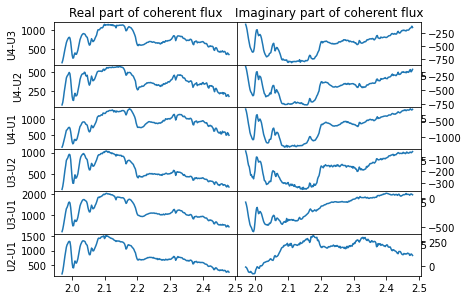

In [17]:
# plot the phase-referenced visibility
import matplotlib.pyplot as plt
from cleanGravity import gravityPlot as gplot
fig = plt.figure()
gplot.reImPlot(np.tile(plaOi.wav*1e6, (plaOi.visOi.nchannel, 1)), plaOi.visOi.visRef.mean(axis = 0), subtitles = plaOi.basenames, fig = fig)

So where are the fringes? We actually can’t see them, because the
visibilities are dominated by the star. So we first need to remove the
stellar component. To do that, you can fit a a low-order polynomial in
wavelength, multiplied by the reference amplitude, to take into account
the chromaticity of this “speckel noise”. Since there can also be some
small fluctuations in the phase, its best to do the fitting with complex
coefficients. The fit is done baseline per baseline, dit per dit:

In [18]:
# fit the stellar component with a polynomial
polyOrder = 4
Y = np.zeros([oi.nwav, 1], 'complex')
X = np.zeros([oi.nwav, polyOrder+1])
starFit = np.zeros([plaOi.visOi.ndit, plaOi.visOi.nchannel, plaOi.nwav], 'complex')
for c in range(plaOi.visOi.nchannel):
    for k in range(polyOrder+1):
        X[:, k] = ampRef[c, :]*((plaOi.wav - plaOi.wav.mean(axis = 0))*1e6)**k
    for dit in range(plaOi.visOi.ndit):
        Y[:, 0] = plaOi.visOi.visRef[dit, c, :]
        A = np.dot(np.linalg.pinv(X), Y)
        starFit[dit, c, :] = np.dot(X, A)[:, 0]        

To overplot the result to the previous figure:

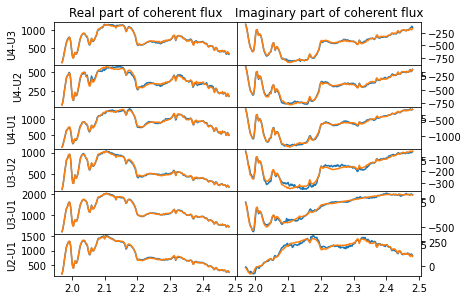

In [20]:
# overplot the result of the fit to the previous fig
fig = plt.figure()
gplot.reImPlot(np.tile(plaOi.wav*1e6, (plaOi.visOi.nchannel, 1)), plaOi.visOi.visRef.mean(axis = 0), subtitles = plaOi.basenames, fig = fig)
gplot.reImPlot(np.tile(oi.wav*1e6, (oi.visOi.nchannel, 1)), starFit.mean(axis = 0), fig = fig)

Now we can subtract this stellar component to the visibilities, and plot
the residuals in a new figure:

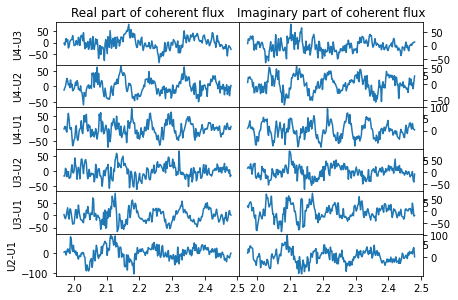

In [21]:
# subtract the stellar component for the planet OI and plot the result
plaOi.visOi.visRef = plaOi.visOi.visRef - starFit
fig = plt.figure()
gplot.reImPlot(np.tile(oi.wav*1e6, (oi.visOi.nchannel, 1)), plaOi.visOi.visRef[0, :, :], subtitles = plaOi.basenames, fig = fig)

Extracting the astrometry
-------------------------

Once the visibilities are properly corrected, and the stellar component
removed, fitting for the astrometry can be done in the same way as for
the swap example:

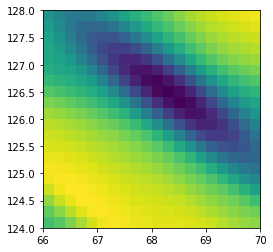

In [22]:
# extract the astrometry using a chi2 map approach
raValues = np.linspace(66, 70, 20) # the ra grid
decValues = np.linspace(124, 128, 20) # the dec grid
chi2Map = np.zeros([plaOi.visOi.ndit, len(raValues), len(decValues)]) # one map for each dit
Y, X = np.zeros([1, 2*plaOi.nwav]), np.zeros([1, 2*plaOi.nwav]) # Y will contain data, X will contain model
planetFit = np.zeros([plaOi.visOi.ndit, plaOi.visOi.nchannel, plaOi.nwav], 'complex') # to save the fit
chi2Min = np.inf
for m in range(len(raValues)):
    for n in range(len(decValues)): # loop through grid
        ra, dec = raValues[m]/1000.0/3600.0/180.0*np.pi, decValues[n]/1000.0/3600.0/180.0*np.pi # convert to rad
        wavelet = np.exp(-1j*2*np.pi*(ra*plaOi.visOi.uCoord+dec*plaOi.visOi.vCoord)) # the visibility model, without the amplitude
        for dit in range(plaOi.visOi.ndit):
            for c in range(plaOi.visOi.nchannel): 
                # here we need to explicitly separate the real/imag parts and do the fitting for the
                # scaling coefficient in real numbers. Otherwise we would get a complex coeff, which
                # means it would also be fitting for the phase offset. 
                X[0, 0:plaOi.nwav] = np.real(wavelet[dit, c, :]) # model
                X[0, plaOi.nwav:] = np.imag(wavelet[dit, c, :]) # model               
                Y[0, 0:plaOi.nwav] = np.real(plaOi.visOi.visRef[dit, c, :]) # data 
                Y[0, plaOi.nwav:] = np.imag(plaOi.visOi.visRef[dit, c, :]) # data
                coeff = np.dot(Y, np.linalg.pinv(X)) # linear fit
                if coeff[0, 0] < 0: # if coeff is negative, set model to 0 and redo the fit
                    coeff[0, 0] = 0
                    X[0, :] = 0
                    coeff = np.dot(Y, np.linalg.pinv(X))
                Yfit = np.dot(coeff, X)
                planetFit[dit, c, :] = Yfit[0, 0:plaOi.nwav] + 1j*Yfit[0, plaOi.nwav:]
                chi2Map[dit, m, n] = chi2Map[dit, m, n]+np.sum((Y-Yfit)**2) # sum of squared differences
        if chi2Map[0, m, n] < chi2Min: # just for the example, we look for best fit on first dit
            bestPlanetFit = np.copy(planetFit)
            chi2Min = chi2Map[dit, m, n]
gplot.reImPlot(np.tile(oi.wav*1e6, (oi.visOi.nchannel, 1)), bestPlanetFit[0, :, :], fig = fig)        
# show the map
plt.figure()
plt.imshow(np.sum(chi2Map, axis = 0).T, origin="lower", extent = [np.min(raValues), np.max(raValues), np.min(decValues), np.max(decValues)])

The last lines are here to overplot the result of the best fit for the
first dit, and to display the $\chi^2$ map.

Although this fit already gives a decent result, it is suboptimal in
many different ways. First off, the amplitude of the fringes of the
planet is not taken into account. To refine the astrometry, a model of
the planet visibility amplitude can be obtained by using a model
contrast spectrum (from a model of the planet and a model of the star),
multiplied by the `ampRef` term calculated from the star exposures.
Then, the stellar subtraction should not be done independantly of the
planet fringes fit, but a complete model, which include both elements,
should be used. And finally, the error terms should be properly taken
into account. The exoGravity pipeline includes all these improvements,
as well as some other minor things.